In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from hyperopt import hp, fmin, tpe, Trials
from IPython.display import display
from deap import base, creator, tools, algorithms
from IPython.display import display
import os
import random

# 数据文件路径
data_dir = './data'
csv_filename = 'data_000001_XSHG_2016-01-01_2025-02-20.csv'
csv_path = os.path.join(data_dir, csv_filename)

# 读取本地CSV文件
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

In [2]:
# 随机指标计算（矢量化）
def Stochastic(high, low, close, k_period, d_period):
    low_min = low.rolling(window=k_period, min_periods=1).min()
    high_max = high.rolling(window=k_period, min_periods=1).max()
    k = 100 * (close - low_min) / (high_max - low_min)
    d = k.rolling(window=d_period, min_periods=1).mean()
    return k, d

# ATR计算（矢量化）
def ATR(high, low, close, period=14):
    tr = pd.DataFrame(index=high.index)
    tr['HL'] = high - low
    tr['HC'] = abs(high - close.shift(1))
    tr['LC'] = abs(low - close.shift(1))
    tr['TR'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    return tr['TR'].rolling(window=period, min_periods=1).mean()

# 矢量化信号检测，区分显性和隐秘强信号
def detect_stochastic_signals_vectorized(df, k_period=14, d_period=3, overbought=80, oversold=20, ma_period=20, atr_period_explicit=14, atr_period_hidden=14, strength_threshold=2):
    df = df.copy()
    k, d = Stochastic(df['high'], df['low'], df['close'], k_period, d_period)
    ma = df['close'].rolling(window=ma_period, min_periods=1).mean()
    vol_ma = df['volume'].rolling(window=5, min_periods=1).mean()
    atr_explicit = ATR(df['high'], df['low'], df['close'], period=atr_period_explicit)
    atr_hidden = ATR(df['high'], df['low'], df['close'], period=atr_period_hidden)
    
    df['signal_strength'] = abs(k - d)
    df['k_amplitude'] = df['high'] - df['low']
    
    support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & (df['close'] < ma)
    resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & (df['close'] > ma)
    
    df['reversal'] = np.select(
        [support_condition, resistance_condition],
        ['support reversal', 'resistance reversal'],
        default='none'
    )
    
    df['is_strong_explicit'] = np.where(
        (df['reversal'] != 'none') & 
        (df['signal_strength'] >= strength_threshold) & 
        (df['k_amplitude'] > atr_explicit),
        1, 0
    )
    
    df['is_strong_hidden'] = np.where(
        (df['reversal'] != 'none') & 
        (df['signal_strength'] >= strength_threshold) & 
        (df['k_amplitude'] < atr_hidden) & 
        (df['volume'] < vol_ma) & 
        (abs(df['close'] - ma) < atr_hidden),
        1, 0
    )
    
    df['is_strong'] = np.where(
        (df['is_strong_explicit'] == 1) | (df['is_strong_hidden'] == 1),
        1, 0
    )
    
    return df

# Numba加速未来范围计算
@njit
def get_future_range_numba(series, look_ahead, is_high=True):
    future_values = np.full(len(series), np.nan)
    for i in range(len(series) - look_ahead):
        if is_high:
            future_values[i] = np.max(series[i+1:i+1+look_ahead])
        else:
            future_values[i] = np.min(series[i+1:i+1+look_ahead])
    return future_values

def calculate_win_rate(df, look_ahead=10, target_multiplier=1):
    df = df.copy()
    df['atr'] = ATR(df['high'], df['low'], df['close'], period=df['atr_period_explicit'].iloc[0] if 'atr_period_explicit' in df.columns else 14)
    
    df['support_target'] = df['close'] + df['atr'] * target_multiplier
    df['resistance_target'] = df['close'] - df['atr'] * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)
    
    df['support_win'] = np.where(
        (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']),
        1, 0
    )
    df['resistance_win'] = np.where(
        (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']),
        1, 0
    )
    
    support_signals = df[df['reversal'] == 'support reversal']
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    
    strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong'] == 1)]
    strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong'] == 1)]
    strong_support_win_rate = strong_support_signals['support_win'].mean() if len(strong_support_signals) > 0 else 0
    strong_resistance_win_rate = strong_resistance_signals['resistance_win'].mean() if len(strong_resistance_signals) > 0 else 0
    
    explicit_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_support_win_rate = explicit_strong_support_signals['support_win'].mean() if len(explicit_strong_support_signals) > 0 else 0
    explicit_strong_resistance_win_rate = explicit_strong_resistance_signals['resistance_win'].mean() if len(explicit_strong_resistance_signals) > 0 else 0
    
    hidden_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_support_win_rate = hidden_strong_support_signals['support_win'].mean() if len(hidden_strong_support_signals) > 0 else 0
    hidden_strong_resistance_win_rate = hidden_strong_resistance_signals['resistance_win'].mean() if len(hidden_strong_resistance_signals) > 0 else 0
    
    support_recall = len(strong_support_signals) / len(support_signals) if len(support_signals) > 0 else 0
    resistance_recall = len(strong_resistance_signals) / len(resistance_signals) if len(resistance_signals) > 0 else 0
    
    return {
        'support_win_rate': support_win_rate,
        'support_signals_count': len(support_signals),
        'resistance_win_rate': resistance_win_rate,
        'resistance_signals_count': len(resistance_signals),
        'strong_support_win_rate': strong_support_win_rate,
        'strong_support_signals_count': len(strong_support_signals),
        'strong_resistance_win_rate': strong_resistance_win_rate,
        'strong_resistance_signals_count': len(strong_resistance_signals),
        'explicit_strong_support_win_rate': explicit_strong_support_win_rate,
        'explicit_strong_support_signals_count': len(explicit_strong_support_signals),
        'explicit_strong_resistance_win_rate': explicit_strong_resistance_win_rate,
        'explicit_strong_resistance_signals_count': len(explicit_strong_resistance_signals),
        'hidden_strong_support_win_rate': hidden_strong_support_win_rate,
        'hidden_strong_support_signals_count': len(hidden_strong_support_signals),
        'hidden_strong_resistance_win_rate': hidden_strong_resistance_win_rate,
        'hidden_strong_resistance_signals_count': len(hidden_strong_resistance_signals),
        'support_recall': support_recall,
        'resistance_recall': resistance_recall,
        'detailed_df': df
    }

In [16]:
# 贝叶斯优化
# 定义参数空间
space = {
    'k_period': hp.quniform('k_period', 9, 20, 1),  # 9-20，步长1，聚焦原有效范围
    'd_period': hp.quniform('d_period', 3, 7, 1),  # 3-7，步长1
    'overbought': hp.quniform('overbought', 70, 90, 5),  # 70-90，步长5
    'oversold': hp.quniform('oversold', 10, 30, 5),  # 10-30，步长5
    'ma_period': hp.quniform('ma_period', 10, 50, 5),  # 10-50，步长5
    'atr_period_explicit': hp.quniform('atr_period_explicit', 7, 20, 1),  # 7-20，步长1
    'atr_period_hidden': hp.quniform('atr_period_hidden', 7, 20, 1),  # 7-20，步长1
    'strength_threshold': hp.quniform('strength_threshold', 0.2, 2, 0.1)  # 1-4，步长0.5，降低上限
}

# 目标函数，调整优化目标以保留更多信号
def objective(params):
    # 转换为整数值
    params_int = {
        'k_period': int(params['k_period']),
        'd_period': int(params['d_period']),
        'overbought': params['overbought'],
        'oversold': params['oversold'],
        'ma_period': int(params['ma_period']),
        'atr_period_explicit': int(params['atr_period_explicit']),
        'atr_period_hidden': int(params['atr_period_hidden']),
        'strength_threshold': params['strength_threshold']
    }
    df_with_signals = detect_stochastic_signals_vectorized(df.copy(), **params_int)
    result = calculate_win_rate(df_with_signals)
    
    # 计算F2得分（β=2，更重视召回率）
    beta = 2
    support_precision = result['support_win_rate']
    support_recall = result['support_recall']
    resistance_precision = result['resistance_win_rate']
    resistance_recall = result['resistance_recall']
    
    support_f2 = (1 + beta**2) * (support_precision * support_recall) / (beta**2 * support_precision + support_recall) if (support_precision + support_recall) > 0 else 0
    resistance_f2 = (1 + beta**2) * (resistance_precision * resistance_recall) / (beta**2 * resistance_precision + resistance_recall) if (resistance_precision + resistance_recall) > 0 else 0
    score = (support_f2 + resistance_f2) / 2
    
    # 添加信号数量惩罚项
    signal_count_penalty = min(result['support_signals_count'], result['resistance_signals_count']) / 100
    adjusted_score = score * signal_count_penalty
    
    return -adjusted_score  # 负值用于最小化

# 执行贝叶斯优化
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=500, trials=trials)
print("Best Parameters from Bayesian Optimization:", best)

# 将best参数转换为实际值
best_params = {
    'k_period': int(best['k_period']),
    'd_period': int(best['d_period']),
    'overbought': best['overbought'],
    'oversold': best['oversold'],
    'ma_period': int(best['ma_period']),
    'atr_period_explicit': int(best['atr_period_explicit']),
    'atr_period_hidden': int(best['atr_period_hidden']),
    'strength_threshold': best['strength_threshold']
}


# 使用最佳参数计算最终信号
df = detect_stochastic_signals_vectorized(df, **best_params)
result = calculate_win_rate(df)

100%|██████████| 500/500 [00:31<00:00, 15.65trial/s, best loss: -0.7519844483656664]
Best Parameters from Bayesian Optimization: {'atr_period_explicit': 18.0, 'atr_period_hidden': 13.0, 'd_period': 3.0, 'k_period': 20.0, 'ma_period': 10.0, 'overbought': 70.0, 'oversold': 30.0, 'strength_threshold': 0.2}


c:\Users\wzzha\miniconda3\envs\futu_trends\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\wzzha\miniconda3\envs\futu_trends\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	200   
1  	400   
2  	400   
3  	400   
4  	400   
5  	400   
6  	400   
7  	400   
8  	400   
9  	400   
10 	400   
11 	400   
12 	400   
13 	400   
14 	400   
15 	400   
16 	400   
17 	400   
18 	400   
19 	400   
20 	400   
21 	400   
22 	400   
23 	400   
24 	400   
25 	400   
26 	400   
27 	400   
28 	400   
29 	400   
30 	400   
31 	400   
32 	400   
33 	400   
34 	400   
35 	400   
36 	400   
37 	400   
38 	400   
39 	400   
40 	400   
41 	400   
42 	400   
43 	400   
44 	400   
45 	400   
46 	400   
47 	400   
48 	400   
49 	400   
50 	400   
51 	400   
52 	400   
53 	400   
54 	400   
55 	400   
56 	400   
57 	400   
58 	400   
59 	400   
60 	400   
61 	400   
62 	400   
63 	400   
64 	400   
65 	400   
66 	400   
67 	400   
68 	400   
69 	400   
70 	400   
71 	400   
72 	400   
73 	400   
74 	400   
75 	400   
76 	400   
77 	400   
78 	400   
79 	400   
80 	400   
81 	400   
82 	400   
83 	400   
84 	400   
85 	400   
86 	400   
87 	400   
88 	400   
89 	400   

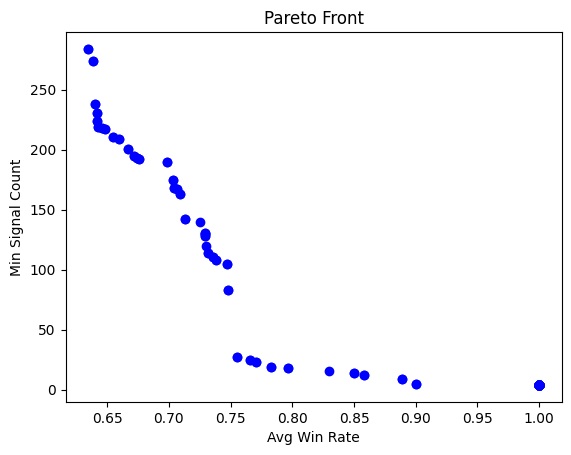

In [21]:
# 遗传算法
# 定义参数空间
creator.create("FitnessMulti", base.Fitness, weights=(0.2, 1.0))  # 胜率:信号数量=0.2:1.0，优先信号数量
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# 参数范围
param_ranges = {
    'k_period': (9, 20),
    'd_period': (3, 7),
    'overbought': (70, 90, 5),
    'oversold': (10, 30, 5),
    'ma_period': (5, 20, 1),
    'atr_period_explicit': (7, 20),
    'atr_period_hidden': (7, 20),
    'strength_threshold': (0.5, 2, 0.1)  # 缩小范围，减少过滤
}

toolbox.register("attr_k_period", random.randint, param_ranges['k_period'][0], param_ranges['k_period'][1])
toolbox.register("attr_d_period", random.randint, param_ranges['d_period'][0], param_ranges['d_period'][1])
toolbox.register("attr_overbought", random.randrange, param_ranges['overbought'][0], param_ranges['overbought'][1] + 1, param_ranges['overbought'][2])
toolbox.register("attr_oversold", random.randrange, param_ranges['oversold'][0], param_ranges['oversold'][1] + 1, param_ranges['oversold'][2])
toolbox.register("attr_ma_period", random.randrange, param_ranges['ma_period'][0], param_ranges['ma_period'][1] + 1, param_ranges['ma_period'][2])
toolbox.register("attr_atr_period_explicit", random.randint, param_ranges['atr_period_explicit'][0], param_ranges['atr_period_explicit'][1])
toolbox.register("attr_atr_period_hidden", random.randint, param_ranges['atr_period_hidden'][0], param_ranges['atr_period_hidden'][1])
toolbox.register("attr_strength_threshold", lambda: round(random.uniform(param_ranges['strength_threshold'][0], param_ranges['strength_threshold'][1]), 1))

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_k_period, toolbox.attr_d_period, toolbox.attr_overbought, toolbox.attr_oversold,
                  toolbox.attr_ma_period, toolbox.attr_atr_period_explicit, toolbox.attr_atr_period_hidden, toolbox.attr_strength_threshold), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 评估函数
def evaluate(individual):
    params = {
        'k_period': max(1, int(individual[0])),
        'd_period': max(1, int(individual[1])),
        'overbought': individual[2],
        'oversold': individual[3],
        'ma_period': max(1, int(individual[4])),
        'atr_period_explicit': max(1, int(individual[5])),
        'atr_period_hidden': max(1, int(individual[6])),
        'strength_threshold': max(0.1, individual[7])
    }
    df_with_signals = detect_stochastic_signals_vectorized(df.copy(), **params)
    result = calculate_win_rate(df_with_signals)
    
    avg_win_rate = (result['support_win_rate'] + result['resistance_win_rate']) / 2
    min_signal_count = min(result['support_signals_count'], result['resistance_signals_count'])
    
    return avg_win_rate, min_signal_count

# 自定义变异函数
def bounded_mutation(individual, mu, sigma, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            if i in [2, 3]:  # overbought, oversold
                individual[i] += random.gauss(mu, sigma) * 5
                individual[i] = max(param_ranges[list(param_ranges.keys())[i]][0], 
                                  min(param_ranges[list(param_ranges.keys())[i]][1], 
                                      round(individual[i] / 5) * 5))
            elif i == 7:  # strength_threshold
                individual[i] += random.gauss(mu, sigma)
                individual[i] = max(param_ranges['strength_threshold'][0], 
                                  min(param_ranges['strength_threshold'][1], 
                                      round(individual[i] * 10) / 10))
            else:  # 其他整数参数
                individual[i] += random.gauss(mu, sigma)
                individual[i] = max(param_ranges[list(param_ranges.keys())[i]][0], 
                                  min(param_ranges[list(param_ranges.keys())[i]][1], 
                                      int(individual[i])))
    return individual,

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.3)
toolbox.register("mutate", bounded_mutation, mu=0, sigma=1, indpb=0.2)  # 减小变异幅度
toolbox.register("select", tools.selNSGA2)

# 遗传算法运行
population = toolbox.population(n=200)  # 增大种群大小
NGEN = 100  # 增加代数
CXPB = 0.6  # 交叉概率
MUTPB = 0.4  # 变异概率，和为1.0

pop, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=200, lambda_=400, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, verbose=True)

# 提取最佳个体
best_individual = tools.selBest(pop, k=1)[0]
best_params = {
    'k_period': int(best_individual[0]),
    'd_period': int(best_individual[1]),
    'overbought': best_individual[2],
    'oversold': best_individual[3],
    'ma_period': int(best_individual[4]),
    'atr_period_explicit': int(best_individual[5]),
    'atr_period_hidden': int(best_individual[6]),
    'strength_threshold': best_individual[7]
}

# 使用最佳参数计算最终信号
df = detect_stochastic_signals_vectorized(df, **best_params)
result = calculate_win_rate(df)
front = np.array([ind.fitness.values for ind in pop])
plt.scatter(front[:, 0], front[:, 1], c='b')
plt.xlabel('Avg Win Rate')
plt.ylabel('Min Signal Count')
plt.title('Pareto Front')
plt.show()


Best Parameters: k_period=20, d_period=6, overbought=93.06783124101317, oversold=8.00285711776648, ma_period=36, atr_period_explicit=14, atr_period_hidden=10, strength_threshold=2.9049261636730717
Overall Support Reversal Win Rate: 100.00% (Signals: 2)
Overall Resistance Reversal Win Rate: 100.00% (Signals: 6)
Strong Support Reversal Win Rate: 0.00% (Signals: 0)
Strong Resistance Reversal Win Rate: 0.00% (Signals: 0)
Explicit Strong Support Win Rate: 0.00% (Signals: 0)
Explicit Strong Resistance Win Rate: 0.00% (Signals: 0)
Hidden Strong Support Win Rate: 0.00% (Signals: 0)
Hidden Strong Resistance Win Rate: 0.00% (Signals: 0)
Support Recall: 0.00%
Resistance Recall: 0.00%

Detailed DataFrame saved to: ./data/stochastic_signals_optimized.csv

Detailed DataFrame (Last 250 Rows):


,open,high,low,close,volume,reversal,signal_strength,is_strong,is_strong_explicit,is_strong_hidden,support_target,resistance_target,future_high,future_low,support_win,resistance_win
2024-02-01,2773.4200,2805.0100,2752.7800,2770.7400,3.528892e+10,none,30.507934,0,0,0,2828.065000,2713.415000,3009.14,2635.09,0,0
2024-02-02,2773.2900,2791.6800,2666.3300,2730.1500,4.262302e+10,none,16.981182,0,0,0,2793.911429,2666.388571,3009.48,2635.09,0,0
2024-02-05,2716.0800,2739.7400,2635.0900,2702.1900,4.789903e+10,none,10.071362,0,0,0,2770.887143,2633.492857,3015.48,2669.67,0,0
2024-02-06,2680.4800,2802.9300,2669.6700,2789.4900,5.028493e+10,none,21.740285,0,0,0,2863.393571,2715.586429,3031.49,2770.53,0,0
2024-02-07,2791.5100,2829.7000,2770.5300,2829.7000,5.471174e+10,none,31.602527,0,0,0,2901.524286,2757.875714,3031.49,2827.90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14,3328.4830,3349.0836,3322.5289,3346.7242,5.323330e+10,none,0.115979,0,0,0,3383.455979,3309.992421,NaN,NaN,0,0
2025-02-17,3355.4171,3357.1212,3333.1948,3355.8296,5.895466e+10,none,2.658645,0,0,0,3392.117464,3319.541736,NaN,NaN,0,0
2025-02-18,3348.9827,3366.0119,3314.3006,3324.4906,5.626792e+10,none,12.843071,0,0,0,3362.362029,3286.619171,NaN,NaN,0,0
2025-02-19,3320.7801,3352.0867,3320.5809,3351.5392,5.029130e+10,none,0.819339,0,0,0,3388.858007,3314.220393,NaN,NaN,0,0


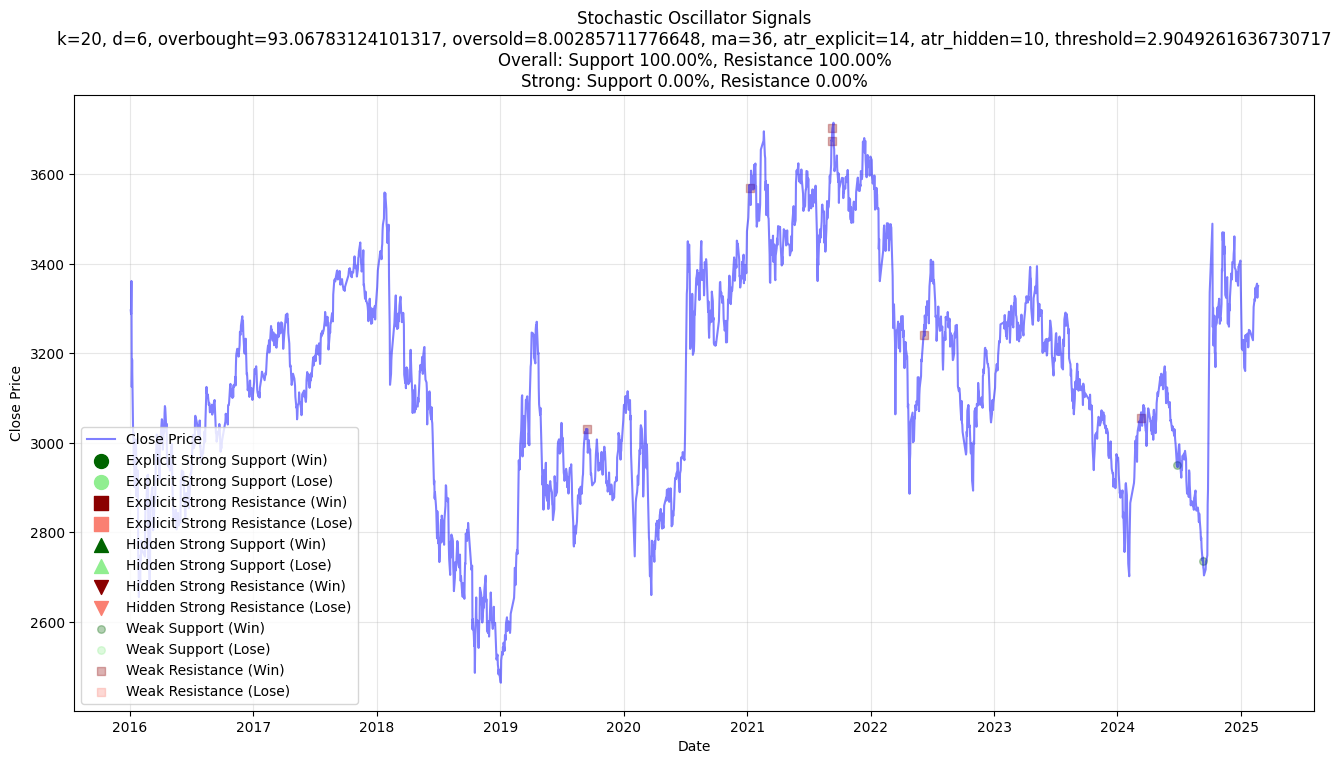

In [20]:
# 输出结果
print(f"\nBest Parameters: k_period={best_params['k_period']}, d_period={best_params['d_period']}, overbought={best_params['overbought']}, oversold={best_params['oversold']}, ma_period={best_params['ma_period']}, atr_period_explicit={best_params['atr_period_explicit']}, atr_period_hidden={best_params['atr_period_hidden']}, strength_threshold={best_params['strength_threshold']}")
print(f"Overall Support Reversal Win Rate: {result['support_win_rate']:.2%} (Signals: {result['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result['resistance_win_rate']:.2%} (Signals: {result['resistance_signals_count']})")
print(f"Strong Support Reversal Win Rate: {result['strong_support_win_rate']:.2%} (Signals: {result['strong_support_signals_count']})")
print(f"Strong Resistance Reversal Win Rate: {result['strong_resistance_win_rate']:.2%} (Signals: {result['strong_resistance_signals_count']})")
print(f"Explicit Strong Support Win Rate: {result['explicit_strong_support_win_rate']:.2%} (Signals: {result['explicit_strong_support_signals_count']})")
print(f"Explicit Strong Resistance Win Rate: {result['explicit_strong_resistance_win_rate']:.2%} (Signals: {result['explicit_strong_resistance_signals_count']})")
print(f"Hidden Strong Support Win Rate: {result['hidden_strong_support_win_rate']:.2%} (Signals: {result['hidden_strong_support_signals_count']})")
print(f"Hidden Strong Resistance Win Rate: {result['hidden_strong_resistance_win_rate']:.2%} (Signals: {result['hidden_strong_resistance_signals_count']})")
print(f"Support Recall: {result['support_recall']:.2%}")
print(f"Resistance Recall: {result['resistance_recall']:.2%}")

# 将完整DataFrame保存为CSV文件
csv_path = './data/stochastic_signals_optimized.csv'
result['detailed_df'].to_csv(csv_path, index=True)
print(f"\nDetailed DataFrame saved to: {csv_path}")

# 显示尾部250行
print("\nDetailed DataFrame (Last 250 Rows):")
display(result['detailed_df'][['open', 'high', 'low', 'close', 'volume', 'reversal', 'signal_strength', 'is_strong', 'is_strong_explicit', 'is_strong_hidden', 'support_target', 'resistance_target', 'future_high', 'future_low', 'support_win', 'resistance_win']].tail(250))

# 可视化改进（使用Matplotlib，放大尺寸并展示胜率）
df_visual = result['detailed_df']
plt.figure(figsize=(16, 8))
plt.plot(df_visual.index, df_visual['close'], label='Close Price', color='blue', alpha=0.5)

# 显性强信号
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1)]['close'],
            color='darkgreen', marker='o', label='Explicit Strong Support (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0)]['close'],
            color='lightgreen', marker='o', label='Explicit Strong Support (Lose)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
            color='darkred', marker='s', label='Explicit Strong Resistance (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
            color='salmon', marker='s', label='Explicit Strong Resistance (Lose)', s=100)

# 隐秘强信号（用不同标记区分）
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1)]['close'],
            color='darkgreen', marker='^', label='Hidden Strong Support (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0)]['close'],
            color='lightgreen', marker='^', label='Hidden Strong Support (Lose)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
            color='darkred', marker='v', label='Hidden Strong Resistance (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
            color='salmon', marker='v', label='Hidden Strong Resistance (Lose)', s=100)

# 弱信号（淡化显示）
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)]['close'],
            color='darkgreen', marker='o', label='Weak Support (Win)', s=30, alpha=0.3)
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)]['close'],
            color='lightgreen', marker='o', label='Weak Support (Lose)', s=30, alpha=0.3)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)]['close'],
            color='darkred', marker='s', label='Weak Resistance (Win)', s=30, alpha=0.3)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)]['close'],
            color='salmon', marker='s', label='Weak Resistance (Lose)', s=30, alpha=0.3)

# 在标题中展示胜率
title = (
    f'Stochastic Oscillator Signals\n'
    f'k={best_params["k_period"]}, d={best_params["d_period"]}, overbought={best_params["overbought"]}, oversold={best_params["oversold"]}, ma={best_params["ma_period"]}, atr_explicit={best_params["atr_period_explicit"]}, atr_hidden={best_params["atr_period_hidden"]}, threshold={best_params["strength_threshold"]}\n'
    f'Overall: Support {result["support_win_rate"]:.2%}, Resistance {result["resistance_win_rate"]:.2%}\n'
    f'Strong: Support {result["strong_support_win_rate"]:.2%}, Resistance {result["strong_resistance_win_rate"]:.2%}'
)
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show()